# Hidden Markov Model and Maximum Likelihood Estimation 

In this notebook, we will see an implementation of maximum likelihood estimation for Hidden Markov Model (HMM), which is described in Chapter 13 of the book PRML. 

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
mpl.rc("savefig",dpi=100)

# 1 Setting

Here, we consider sequential data.

* $N \in \mathbb{N}$ : the number of observation data
* $X = (x_0, x_1, \dots, x_{N-1})$ : the set of observation data. All $x_n$ belong to a pre-specified set.

Here we assume that $(x_0, x_1, \dots, x_{N-1})$ is obtained from a single sequence. If we want to use multiple sequences, than the algorithms discussed below should be appropriately modified.

# 2. Theory


## 2.1 Model

* $K \in \mathbb{N}$ : the number of latent states
* $Z = (z_0, z_1, \dots, z_{N-1})$ : the set of latent variable. $z_n \in \{ 0,1 \}^K$, and $\sum_{k=0}^{K-1}z_{n,k} = 1$

The joint distribution of $X$ and $Z$ is given by 

$$
\begin{align}
    p\left( X, Z \middle| \theta \right) = 
    p\left( z_0 \middle| \pi \right)
    \left[ \prod_{n=1}^{N-1} p\left( z_n \middle| z_{n-1} , A\right) \right]
    \left[ \prod_{n=0}^{N-1}  p\left( x_n \middle| z_n, \phi \right) \right]
\end{align}
$$

where

$$
\begin{align}
    \theta &= \left( \pi, A, \phi \right) \\
    p\left( z_0 \middle| \pi \right) &= \prod_{k=0}^{K-1} \pi_{k}^{z_{0,k}}  \\
    p\left( z_n \middle| z_{n-1}, A \right) &=  \prod_{k=0}^{K-1} \prod_{j=0}^{K-1} A_{j,k} ^{z_{n-1,j} z_{n,k}} \\
    p\left( x_n \middle| z_n, \phi \right) &= \prod_{k=0}^{K-1} p(x_n | \phi_k)^{z_{n,k}}
\end{align}
$$

* $\pi \in [0,1]^{K}$ : $\pi_k$ stands for the probability that $z_{0,k}=1$. It has to satisfy $\sum_{k=0}^{K-1} \pi_k = 1$ and $\pi_k \geq 0$. 
* $A = \left( A_{j,k} \right)_{j,k = 0,1,\dots, K-1}$ : $A_{j,k} = p(z_{n,k}=1 | z_{n-1,j}=1)$, i.e., $A_{j,k}$ stands for the transition probability from state $j$ to state $k$.
* $\phi = \left( \phi_k \right)_{k=0,1, \dots, K-1}$ : the parameters for emission probability $p\left(x \middle| z, \phi \right)$.

## 2.2 Maximum Likelihood Estimation : EM algorithm

Our goal here is to obtain $\theta$ that maximizes
\begin{align}
    p(X|\theta) = \sum_{Z} p(X,Z|\theta)
\end{align}
Because here we have latent variables $Z$, we can utilise EM algorithm to perform the maximization. 

To be more concrete, we perform the following calculation

0. input : $\theta_{ini}$, $X$.
1. $\theta^{old} \leftarrow \theta_{ini}$
2. while not converge
    1. E-step : Calculate $Q(\theta, \theta^{old}) := \sum_{Z} p \left( Z \middle| X,\theta^{old} \right) \log p(X,Z|\theta)$ as a function of $\theta$
    2. M-step : Let $\theta_M$ be $\theta$ that maximizes $Q(\theta, \theta^{old})$, and set $\theta^{old} \leftarrow \theta_M$

### 2.2.1 E-step

The function $Q(\theta, \theta^{old})$ is given by

$$
\begin{align}
    Q(\theta, \theta^{old}) &= 
    \sum_{k=0}^{K-1} \gamma_{0,k} \log \pi_k 
    {} + \sum_{n=1}^{N-1} \sum_{j,k=0}^{K-1} \xi_{n,j,k} \log A_{j,k} 
    {} + \sum_{n=0}^{N-1} \sum_{k=0}^{K-1} \gamma_{n,k} \log p(x_n | \phi_k) \\
    \gamma_{n,k} &:= p(z_{n,k}=1 | X, \theta^{old}) \ \ (n \geq 0) \\
    \xi_{n,j,k} &:= p(z_{n-1,j}=1 , z_{n,k}=1 | X, \theta^{old}) \ \ (n \geq 1)
\end{align}
$$

The quantities $\gamma$ and $\xi$ can be obtained as follows (See Sections 13.2.2 and 13.2.4 of the book.)
$$
\begin{align}
    \gamma_{n,k} &=  \hat{\alpha}_{n,k} \hat{\beta}_{n,k} \\
    \hat{\alpha}_{n,k} &:= p(z_{n,k}=1 | x_0, \dots, x_n ) \\
    \hat{\beta}_{n,k} &:= \frac{p(x_{n+1}, \dots, x_{N-1} | z_{n,k} = 1)}{ p(x_{n+1}, \dots, x_{N-1} | x_0, \dots, x_n) } \ \ (n= 0, 1, \dots, N-2) \\
    \hat{\beta}_{N-1,k} &:= 1 \\
    \xi_{n,j,k} &= \frac{1}{c_n} \hat{\alpha}_{n-1,j} p(x_n|\phi_{k}^{old}) A_{j,k}^{old} \hat{\beta}_{n,k}
\end{align}
$$

where $\hat{\alpha}$ and $\hat{\beta}$ can be calculated recursively : 
$$
\begin{align}
    \hat\alpha_{0,k} &= \frac{\pi_k p(x_0 | \phi_{k}^{old})}{ \sum_{j=0}^{K-1}\pi_j p(x_0 | \phi_{j}^{old}) } \\
    c_0 &= \sum_{j=0}^{K-1}\pi_j p(x_0 | \phi_{j}^{old}) \\
    c_n \hat\alpha_{n,k} &= p(x_n | \phi_{k}^{old}) \sum_{j=0}^{K-1} \hat\alpha_{n-1,j} A_{j,k}^{old} \\
    c_{n+1} \hat\beta_{n,k} &= \sum_{j=0}^{K-1} \hat\beta_{n+1,j} p(x_{n+1}|\phi_{j}^{old}) A_{k,j}^{old} \\
    \hat\beta_{N-1,k} &= 1
\end{align}
$$

Note that $c_n$ can be obtained as a normalization constant of $\hat{\alpha}$. 

### 2.2.2 M-step

The maximization w.r.t $\pi$ and $A$ can be easily performed, as the results are given by
$$
\begin{align}
    \pi_k &= \frac{\gamma_{0,k}}{\sum_{j=0}^{K-1} \gamma_{0,j}} \\
    A_{j,k} &= \frac{ \sum_{n=1}^{N-1} \xi_{n,j,k} }{  \sum_{n=1}^{N-1} \sum_{l=0}^{K-1} \xi_{n,j,l}  }
\end{align}
$$

The maximization w.r.t. $\phi$ depends on the specific form of emission probability. 

As an example, let us consider the case where the emission probability is a Bernoulli distribution: 
$$
\begin{align}
    p(x|\phi_k) = \phi_{k}^{x} \left( 1 - \phi_{k} \right)^{1-x} 
\end{align}
$$
with $x \in \{ 0,1 \}$ and $\phi_k \in [0,1]$.
For this emissoin probability, the M-step gives
$$
\begin{align}
    \phi_k = \frac{ \sum_{n=0}^{N-1} \gamma_{n,k} x_n }{ \sum_{n=0}^{N-1} \gamma_{n,k}}
\end{align}
$$

### 2.2.3 Llikelihood

The likelihood can be obtained by 
$$
\begin{align}
    p(X) = \prod_{n=0}^{N-1} c_n
\end{align}
$$

We will use (the log of ) the value to monitor the convergence.

# 3 From math to code

In this section, we describe `HMM` class, which implements the hidden Markov model and its training described so far.

For concreteness, we only consider the cases where the emission probability is a Bernoulli distribution: 
$$
\begin{align}
    p(x|\phi_k) = \phi_{k}^{x} \left( 1 - \phi_{k} \right)^{1-x} 
\end{align}
$$
with $x \in \{ 0,1 \}$ and $\phi_k \in [0,1]$.

In the following code, we use `alpha` and `beta` to represent $\hat{\alpha}$ and $\hat{\beta}$ respectively.

## 3.1 Properties and methods

We let our `HMM` class has the following properties and methods.

### Properties

* `K` : $K$, i.e., an positive integer representing the number of latent components
* `pi`: $\pi$, i.e., `(K,)` array representing the initial distribution
* `A` : $A$, i.e., `(K, K)` array representing the transition matrix
* `phi` : $\phi$, i.e., the parameters governing the emission probability


### Methods

We decompose E step into several methods.

* `_init_params` : Initializes parameteres `pi`, `A`, `phi` for EM algorithm. Initialization can be done by hand, or done at random
* `_calc_pmatrix` : Calculates and returns a 2D array pmatrix, where `pmatrix[n, k]` = $p(x_n | \phi_k)$ for forward and backward process
* `_forward` : Performs forward process and returns `alpha` and `c` (the normalization constant)
* `_backward` : Performs backward process and returns `beta`
* `_estep` : Calculates and returns `gamma` and `xi` from the inputs including `alpha`, `beta` and `c`
* `_mstep` : Performs M step, i.e., updates parameters `pi, A, phi`, using the result of E step
* `fit` : Performs fitting with EM algorithm
* `predict_proba` : Calculates and returns the probability that latent variables corresponding to the input X are in each class.
* `predict` : Calculates and returns which classes the latent variables corresponding to the input X are in.


## 3.2 Code

In [2]:
class HMM:
    
    def __init__(self, K):
        self.K = K
        self.pi = None
        self.A = None
        self.phi = None
        
        
    def _init_params(self, pi=None, A=None, phi=None, seed_pi=None, seed_A=None, seed_phi=None):
        '''
        Initializes parameters pi, A, phi for EM algorithm
        '''
        self.pi =  pi if (pi is not None) else np.random.RandomState(seed=seed_pi).dirichlet(alpha=np.ones(self.K))
        self.A = A if (A is not None) else np.random.RandomState(seed=seed_A).dirichlet(alpha=np.ones(self.K), size=self.K)
        self.phi = phi if (phi is not None) else np.random.RandomState(seed=seed_phi).rand(self.K)  # emissoin probability dependent
        
    def _calc_pmatrix(self, X):
        '''
        Calculates a 2D array pmatrix (pmatrix[n, k] = $p (x_n | \phi_k)$) for E step. 
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        
        Returns
        ----------
        pmatrix : 2D numpy array
            (len(X), self.K) numpy array
        '''
        pmatrix = (self.phi**X) * ((1-self.phi)**(1-X)) # emissoin probability dependent
        return pmatrix
        
    
    def _forward(self, pmatrix):
        '''
        Performs forward process and returns alpha and c (the normalization constant)
        
        Parameters
        ----------
        pmatrix : 2D numpy array
            (N, self.K) numpy array, where pmatrix[n, k] = $p (x_n | \phi_k)$
        
        Returns
        ----------
        alpha : 2D numpy array
            (N, self.K) numpy array
        
        c :  1D numpy array
            (N,) numpy array
        '''
        N = len(pmatrix)
        alpha = np.zeros((N, self.K))
        c = np.zeros(N)
        tmp = self.pi * pmatrix[0]
        c[0] = np.sum(tmp)
        alpha[0] = tmp / c[0]
        
        for n in range(1, N, 1):
            tmp = pmatrix[n] * ( (self.A).T @  alpha[n-1] )
            c[n] = np.sum(tmp)
            alpha[n] = tmp / c[n]
        return alpha, c
    
    def _backward(self, pmatrix, c):
        '''
        Performs backward process and returns beta
        
        Parameters
        ----------
        pmatrix : 2D numpy array
            (N, self.K) numpy array
        c :  1D numpy array
            (N,) numpy array
        
        Returns
        ----------
        beta : 2D numpy array
            (N, self.K) numpy array
        '''
        N = len(pmatrix)
        beta = np.zeros((N, self.K))
        beta[N - 1] = np.ones(self.K)
        for n in range(N-2, -1, -1):
            beta[n] = self.A @ ( beta[n+1] * pmatrix[n+1] ) / c[n+1]
        return beta
    
    def _estep(self, pmatrix, alpha, beta, c):
        '''
        Calculates and returns gamma and xi from the inputs including alpha, beta and c
        
        Parameters
        ----------
        pmatrix : 2D numpy array
            (N, self.K) numpy array
        alpha : 2D numpy array
            (N, self.K) numpy array
        beta : 2D numpy array
            (N, self.K) numpy array
        c :  1D numpy array
            (N,) numpy array
        
        Returns
        ----------
        gamma : 2D numpy array
            (N, self.K) array
        xi : 3D numpy array
            (N, self.K, self.K) array. Note that xi[0] is meaningless.
        '''

        gamma = alpha * beta
        xi = np.roll(alpha, shift=1, axis=0).reshape(N, self.K, 1) * np.einsum( "jk,nk->njk", self.A, pmatrix * beta) / np.reshape( c, (N, 1,1))
        return gamma, xi
            
    def _mstep(self, X, gamma, xi):
        '''
        Performs M step, i.e., updates parameters pi, A, phi, using the result of E step
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        gamma : 2D numpy array
            (N, self.K) array
        xi : 3D numpy array
            (N, self.K, self.K) array
        '''
        self.pi = gamma[0] / np.sum(gamma[0])
        xitmp = np.sum(xi[1:], axis=0)
        self.A = xitmp / np.reshape(np.sum(xitmp, axis=1) , (self.K, 1))
        self.phi = (gamma.T @ X[:,0])  / np.sum(gamma, axis=0)
        
    
    def fit(self, X, max_iter=1000, tol=1e-3, **kwargs):
        '''
        Performs fitting with EM algorithm
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        max_iter : positive int
            The maximum number of iteration allowed
        tol : positive float
            Threshold for termination of iteration. 
        '''
        self._init_params(**kwargs)
        log_likelihood = -np.inf
        for i in range(max_iter):
            pmatrix = self._calc_pmatrix(X)
            alpha, c = self._forward(pmatrix)
            beta = self._backward(pmatrix, c)
            gamma, xi = self._estep(pmatrix, alpha, beta, c)
            self._mstep(X, gamma, xi)
            
            log_likelihood_prev = log_likelihood
            log_likelihood = np.sum(np.log(c))
            if abs(log_likelihood - log_likelihood_prev) < tol:
                break
        print(f"The number of iteration : {i}")
        print(f"Converged : {i < max_iter - 1}")
        print(f"log likelihood : {log_likelihood}")
        
    def predict_proba(self, X):
        '''
        Calculates and returns the probability that latent variables corresponding to the input X are in each class.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        gamma : 2D numpy array
            (len(X), self.K) numpy array, where gamma[n, k] represents the probability that 
            the lantent variable corresponding to the n-th sample of X belongs to the k-th class.
        '''
        pmatrix = self._calc_pmatrix(X)
        alpha, c = self._forward(pmatrix)
        beta = self._backward(pmatrix, c)
        gamma = alpha * beta
        return gamma
    
    def predict(self, X):
        '''
        Calculates and returns which classes the latent variables corresponding to the input X are in.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        pred : 2D numpy array
            (len(X), self.K) numpy array, where gamma[n, k] represents the probability that 
            the lantent variable corresponding to the n-th sample of X belongs to the k-th class.
        '''
        pred = self.predict_proba(X).argmax(axis=1)
        return pred
        

## 4. Experiment

For illustration, we consider a toy data, which is generated from a two-state coin. 
In state $j$, the probability of getting head is $\mu_j$. 
After each coin toss, the coin can change its state stochastically. 

In [3]:
N = 200 # the number of data

# Here we consider a heavily biased coin.
mu0 = 0.1
mu1 = 0.8

tp = 0.03 # transition probability

rv_cointoss = np.random.RandomState(seed=0).rand(N)
rv_transition = np.random.RandomState(seed=1).rand(N)

X = np.zeros((N, 1))
states = np.zeros(N)
current_state = 0
for n in range(N):
    states[n] = current_state
    if rv_cointoss[n] < mu0*(int(not(current_state))) + mu1*current_state:
        X[n][0] = 1.0
    if rv_transition[n] < tp:
        current_state = int(not(current_state))

We can visualize the data as follows (To prevent overlapping, we properly scaled and shifted the data.). It can be seen that when the latent variable (the internal state of the coin) is 0, the coin is more prone to output 0, and vice versa.

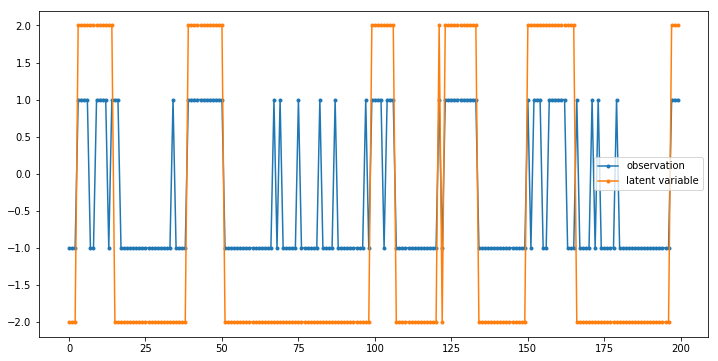

In [4]:
plt.figure(figsize=(12,6))
plt.plot(2*X[:,0]-1,'.-',label='observation')
plt.plot(4*states-2,'.-',label='latent variable')
plt.legend()
plt.show()

Let us apply our `HMM` class to this data. Here we choose `K=2` for simplicity.

In [5]:
hmm = HMM(K=2)
hmm.fit(X, seed_pi=0, seed_A=1, seed_phi=2)

The number of iteration : 10
Converged : True
log likelihood : -97.79439002318189


Let us first take a look at the parameters.

In [6]:
print(f"pi : {hmm.pi}")
print(f"A : {hmm.A}")
print(f"phi : {hmm.phi}")

pi : [1.01243169e-11 1.00000000e+00]
A : [[0.87599792 0.12400208]
 [0.06322307 0.93677693]]
phi : [0.87238852 0.08079113]


The model properly learned that transitions between different latent states are rare, and that the state 0 is prone to output 1.
NOTE: The labeling of latent states is somewhat arbitrary (i.e., exchanging the labels does not affect the output of the model), and here the label of the latent states we obtained is the opposite to those we used for generating data.

Let us visualize the estimated latent states.

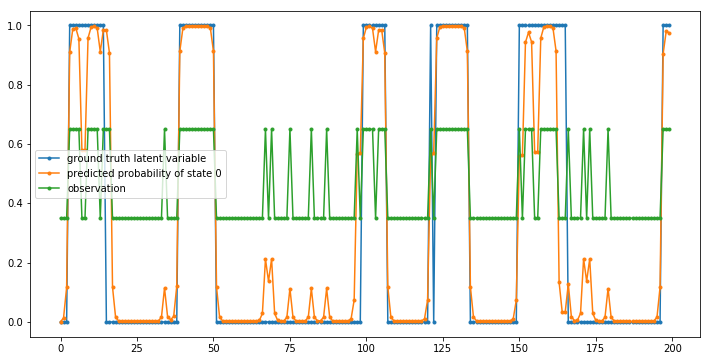

In [7]:
plt.figure(figsize=(12,6))
plt.plot(states, '.-', label='ground truth latent variable')
plt.plot(hmm.predict_proba(X)[:,0], '.-', label='predicted probability of state 0')
plt.plot(0.3*X[:,0]+0.35,'.-',label='observation')
plt.legend()

The result shows good agreement between the ground truth latent variables we used for generating the data and the estimated lantet variables.